In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ecdc_data = pd.concat([pd.read_csv("./ECDC_surveillance_data_Rubella.csv"),
                       pd.read_csv("./ECDC_surveillance_data_Measles.csv"),
                       pd.read_csv("./ECDC_surveillance_data_Mumps.csv")])
ecdc_data

,HealthTopic,Population,Distribution,Unit,Time,RegionCode,RegionName,CategoryIndex,Category,Value
0,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,1,<1,0.000000000
1,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,2,1-4,0.000000000
2,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,3,5-9,0.000000000
3,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,4,10-14,0.000000000
4,Rubella,All cases,Age-specific rate,N/1000000,2007-01,UK,United Kingdom,5,15-19,0.000000000
...,...,...,...,...,...,...,...,...,...,...
458,Mumps,All cases,Gender-specific rate,N/100000,2016,UK,United Kingdom,2,Female,1.414653950
459,Mumps,All cases,Gender-specific rate,N/100000,2017,UK,United Kingdom,1,Male,3.248178910
460,Mumps,All cases,Gender-specific rate,N/100000,2017,UK,United Kingdom,2,Female,2.916281670
461,Mumps,All cases,Gender-specific rate,N/100000,2018,UK,United Kingdom,1,Male,1.797617820


In [3]:
ecdc_data = ecdc_data.loc[lambda s: s['Population'] == 'All cases']
ecdc_age = ecdc_data.loc[lambda s: s['Distribution'] == "Age-specific rate"][['Time', 'Category', 'Value', 'HealthTopic']]

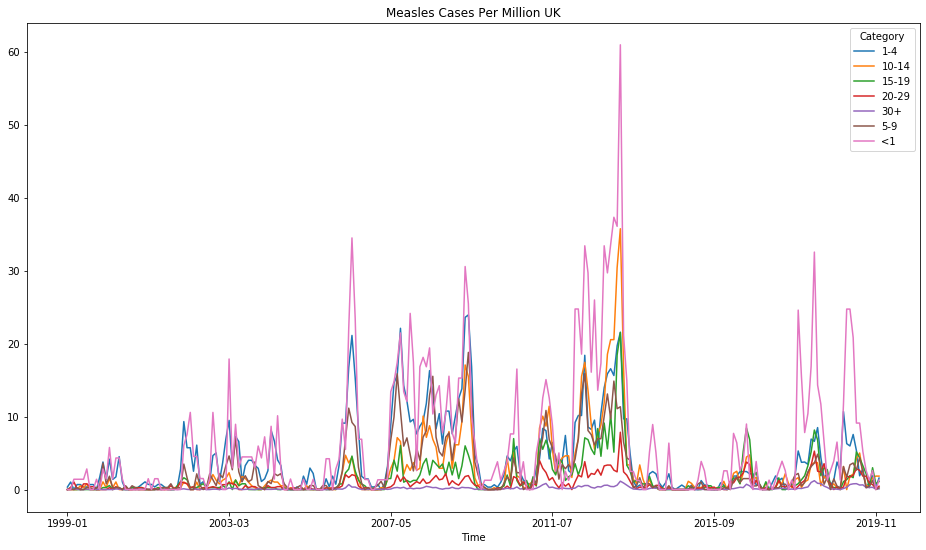

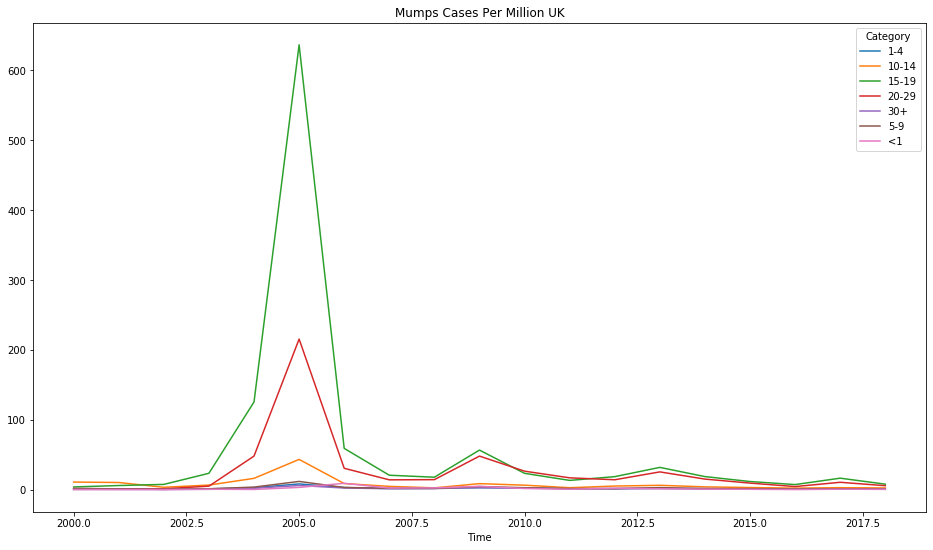

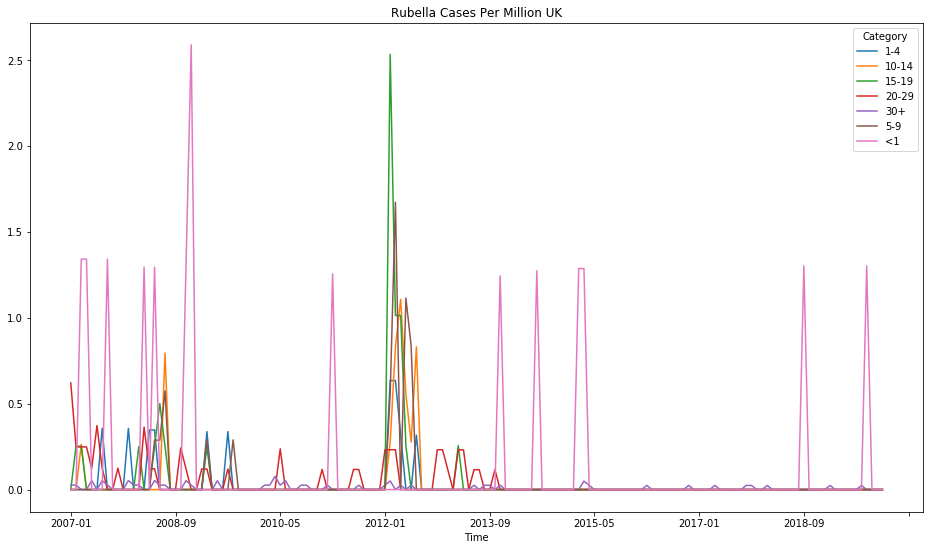

In [4]:
for d in ['Measles', 'Mumps', 'Rubella']:
    ecdc_temp = ecdc_age.loc[lambda s: s['HealthTopic'] == d][['Time', 'Category', 'Value']]
    ecdc_temp = ecdc_temp.pivot(index='Time', columns='Category', values='Value')
    ecdc_temp = ecdc_temp.apply(pd.to_numeric)
    plot = ecdc_temp.plot(figsize=(16,9),title=d+" Cases Per Million UK")
    plt.savefig(d+"Plot")